In [ ]:
import os
import psycopg2
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle

import tempfile
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata

In [2]:
def get_db_connection():
    try:
        conn = psycopg2.connect(
            host="172.27.80.1",
            database="calpuff",
            user="postgres",
            password="1201"
        )
        print("데이터베이스에 연결되었습니다.")
        return conn
    except Exception as e:
        print("데이터베이스 연결에 실패했습니다:", e)
        return None

In [ ]:
def get_time_range():
    """DB에서 timestamp의 최소값과 최대값을 조회"""
    conn = get_db_connection()
    if conn is None:
        return None, None
    
    cursor = conn.cursor()
    try:
        query = """
        SELECT MIN(timestamp), MAX(timestamp)
        FROM WRF_2024_01_NC
        """
        cursor.execute(query)
        start_time, end_time = cursor.fetchone()
        return start_time, end_time
    
    except Exception as e:
        print('시간 범위 조회에 실패했습니다:', e)
        return None, None
    finally:
        cursor.close()
        conn.close()

def fetch_data_by_timestamp(timestamp, output_dir):
    conn = get_db_connection()
    if conn is None:
        return None
    
    cursor = conn.cursor()
    try:
        query = """
        SELECT nc_data
        FROM WRF_2024_01_NC 
        WHERE timestamp = %s
        """
        cursor.execute(query, (timestamp,))
        result = cursor.fetchone()
        
        if result is None:
            print(f"{timestamp}에 대한 데이터가 없습니다.")
            return None

        binary_data = result[0]
        
        filename = f"wrfout_d01_{timestamp.strftime('%Y-%m-%d_%H:%M:%S')}.nc"
        output_path = os.path.join(output_dir, filename)
        
        # 바이너리 데이터를 NetCDF 파일로 저장
        with open(output_path, 'wb') as f:
            f.write(binary_data)
        
        # 저장된 파일을 Dataset으로 로드
        ds = xr.open_dataset(output_path)
        print(f"{timestamp} 데이터가 성공적으로 복원되었습니다.")
        return ds
    except Exception as e:
        print(f"{timestamp} NetCDF 파일 로드에 실패했습니다:", e)
        return None
    finally:
        cursor.close()
        conn.close()
    
def process_all_timestamps():
    output_dir = 'wrf_output'
    os.makedirs(output_dir, exist_ok=True)
    
    start_time, end_time = get_time_range()
    if start_time is None or end_time is None:
        print('시간 범위를 가져오는데 실패했습니다.')
        return
    
    success_count = 0
    fail_count = 0
    
    current_time = start_time
    while current_time <= end_time:
        print(f'\n처리 중: {current_time}')
        
        if fetch_data_by_timestamp(current_time, output_dir):
            success_count += 1
        else:
            fail_count += 1
            
        current_time += timedelta(hours=1)
        
    print(f'\n처리 완료:')
    print(f'성공: {success_count} 파일')
    print(f'실패: {fail_count} 파일')
    print(f'출력 디렉토리: {os.path.abspath(output_dir)}')
    
def main():
    print('WRF 데이터 nc 파일 변환 시작 ...')
    process_all_timestamps()
    print('변환 작업 완료')

if __name__ == '__main__':
    main()


In [ ]:
import xarray as xr

file_path = '/home/yurim2/WRF/SQL/wrf_output/wrfout_d01_2024-01-01_01:00:00.nc'
ds = xr.open_dataset(file_path)

print(ds)

In [ ]:
xlong = ds['XLONG'].isel(Time = 0)

print(xlong)

In [ ]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.interpolate import griddata

file_directory = '/home/yurim2/WRF/SQL/wrf_output/'

# wrfout_d01_2024-01로 시작하는 파일을 모두 불러오기
file_paths = sorted(glob.glob(file_directory + 'wrfout_d01_2024-01-01_0*'))

# Shapefile 불러오기 (로드뷰용)
shapefile_path = "/home/yurim2/WRF/pohang_shp/pohang.shp"
gdf = gpd.read_file(shapefile_path)
minx, miny, maxx, maxy = gdf.total_bounds  # Shapefile 경계 범위

def load_data(file_path):
    ds = xr.open_dataset(file_path)

    # 위도, 경도, U, V, T2 데이터 가져오기
    xlat = ds['XLAT'].isel(Time=0)  # 위도
    xlong = ds['XLONG'].isel(Time=0)  # 경도
    t2 = ds['T2'].isel(Time=0)  # 2m 온도
    u = ds['U'].mean(dim='bottom_top').isel(Time=0)  # 지표면에서의 U 성분
    v = ds['V'].mean(dim='bottom_top').isel(Time=0)  # 지표면에서의 V 성분
    u_adjusted = 0.5 * (u[:, :-1] + u[:, 1:])  # 격자 보정
    v_adjusted = 0.5 * (v[:-1, :] + v[1:, :])  # 격자 보정

    # 섭씨로 변환
    t2_celsius = t2 - 273.15

    return xlat, xlong, t2_celsius, u_adjusted, v_adjusted

fig = plt.figure(figsize=(14, 12))  # 기존보다 더 큰 크기
gs = GridSpec(1, 2, width_ratios=[4, 0.1])

ax_plot = fig.add_subplot(gs[0])  # Main plot
ax_plot.set_xlim(128.88, 129.6)  # 경도 범위 설정
ax_plot.set_ylim(35.82, 36.35)  # 위도 범위 설정
xlat, xlong, t2, u_adjusted, v_adjusted = load_data(file_paths[0])

levels = np.arange(-15.0, 10.0, 0.5)

# Plot initial temperature contour
contour = ax_plot.contourf(xlong, xlat, t2, cmap='coolwarm', levels=levels)
colorbar = fig.colorbar(contour, ax=ax_plot, label='Temperature (°C)', fraction=0.04, pad=0.05)

# 바람 벡터 추가
quiver = ax_plot.quiver(xlong, xlat, u_adjusted, v_adjusted, scale=300, color='green')  # 보간된 바람 벡터
# quiver = ax_plot.quiver([], [], [], [], scale=300, color='green')

# Shapefile 로드뷰 추가 (지도 경계선)
gdf.plot(ax=ax_plot, edgecolor='black', facecolor='none')  # 로드뷰 플롯

def update(frame):
    global contour, quiver  # 전역 변수 선언

    # 이전 프레임의 contour와 quiver 지우기
    for c in contour.collections:
        c.remove()
    quiver.remove()

    xlat, xlong, t2, u_adjusted, v_adjusted = load_data(file_paths[frame])

    # 온도 등고선
    contour = ax_plot.contourf(xlong, xlat, t2, cmap='coolwarm', levels=levels, vmin=-20, vmax=20)
    colorbar = fig.colorbar(contour, ax=ax_plot, label='Temperature (°C)', fraction=0.04, pad=0.05)

    # 바람 벡터 업데이트
    quiver = ax_plot.quiver(xlong, xlat, u_adjusted, v_adjusted, scale=300, color='green')

    # 지도 경계선(로드뷰) 업데이트
    gdf.plot(ax=ax_plot, edgecolor='black', facecolor='none')  # 로드뷰 플롯

    # 경도, 위도 범위 및 기타 설정 유지
    ax_plot.set_xlim(128.88, 129.6)
    ax_plot.set_ylim(35.82, 36.35)
    ax_plot.set_title(f'Time: {file_paths[frame]}')
    ax_plot.set_xlabel('Longitude')
    ax_plot.set_ylabel('Latitude')

# Animation settings
ani = animation.FuncAnimation(fig, update, frames=len(file_paths), interval=2000, repeat=True)

# Show animation
plt.show()

# Save animation (optional)
writer = animation.FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('./2024_01_01_test_li_wind_temp_animation.mp4', writer=writer)

# Optionally save as GIF
ani.save('./2024_01_01_test_li_wind_temp_animation.gif', writer='imagemagick')

## 한번에

WRF 데이터 nc 파일 변환 후 그래프 작업 ...
데이터베이스에 연결되었습니다.

처리 중: 2024-01-01 01:00:00
데이터베이스에 연결되었습니다.
2024-01-01 01:00:00 데이터가 성공적으로 복원되었습니다.

처리 중: 2024-01-01 02:00:00
데이터베이스에 연결되었습니다.
2024-01-01 02:00:00 데이터가 성공적으로 복원되었습니다.

처리 중: 2024-01-01 03:00:00
데이터베이스에 연결되었습니다.
2024-01-01 03:00:00 데이터가 성공적으로 복원되었습니다.

처리 중: 2024-01-01 04:00:00
데이터베이스에 연결되었습니다.
2024-01-01 04:00:00 데이터가 성공적으로 복원되었습니다.


MovieWriter imagemagick unavailable; using Pillow instead.


그래프 작업 완료


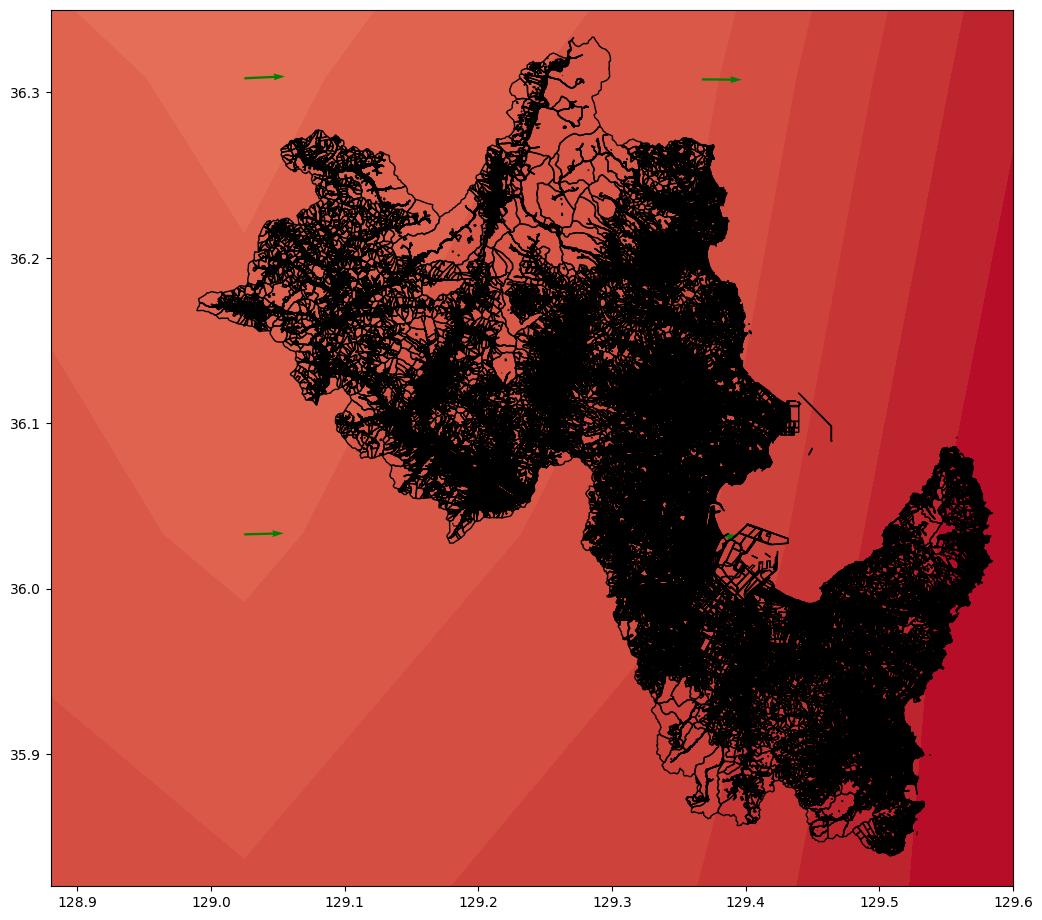

In [ ]:
def get_time_range():
    """DB에서 timestamp의 최소값과 최대값을 조회"""
    conn = get_db_connection()
    if conn is None:
        return None, None
    
    cursor = conn.cursor()
    try:
        query = """
        SELECT MIN(timestamp), MAX(timestamp)
        FROM WRF_2024_01_NC
        """
        cursor.execute(query)
        start_time, end_time = cursor.fetchone()
        return start_time, end_time
    
    except Exception as e:
        print('시간 범위 조회에 실패했습니다:', e)
        return None, None
    finally:
        cursor.close()
        conn.close()

def fetch_data_by_timestamp(timestamp):
    conn = get_db_connection()
    if conn is None:
        return None
    
    cursor = conn.cursor()
    try:
        query = """
        SELECT nc_data
        FROM WRF_2024_01_NC 
        WHERE timestamp = %s
        """
        cursor.execute(query, (timestamp,))
        result = cursor.fetchone()
        
        if result is None:
            print(f"{timestamp}에 대한 데이터가 없습니다.")
            return None

        binary_data = result[0]
        
        # 임시 파일 생성
        with tempfile.NamedTemporaryFile(delete=False, suffix=".nc") as tmp_file:
            tmp_file.write(binary_data)
            tmp_file_path = tmp_file.name

        # 저장된 임시 파일을 Dataset으로 로드
        ds_result = xr.open_dataset(tmp_file_path)
        print(f"{timestamp} 데이터가 성공적으로 복원되었습니다.")
        
        return ds_result, tmp_file_path  # 파일 경로도 반환하여 나중에 삭제
    
    except Exception as e:
        print(f"{timestamp} NetCDF 파일 로드에 실패했습니다:", e)
        return None
    finally:
        cursor.close()
        conn.close()

def process_all_timestamps():
    start_time, end_time = get_time_range()
    if start_time is None or end_time is None:
        print('시간 범위를 가져오는데 실패했습니다.')
        return
    
    file_paths = []
    current_time = start_time
    while current_time <= end_time:
        print(f'\n처리 중: {current_time}')
        
        result = fetch_data_by_timestamp(current_time)
        if result is not None:
            ds, file_path = result
            file_paths.append(file_path)
        else:
            print(f"{current_time}의 데이터 처리에 실패했습니다.")

        current_time += timedelta(hours=1)
        
    create_animation(file_paths)

def create_animation(file_paths):
    fig = plt.figure(figsize=(14, 12))
    gs = GridSpec(1, 2, width_ratios=[4, 0.1])
    ax_plot = fig.add_subplot(gs[0])

    shapefile_path = "/home/yurim2/WRF/pohang_shp/pohang.shp"
    gdf = gpd.read_file(shapefile_path)
    minx, miny, maxx, maxy = gdf.total_bounds

    def load_data(file_path):
        ds = xr.open_dataset(file_path)
        xlat = ds['XLAT'].isel(Time=0)
        xlong = ds['XLONG'].isel(Time=0)
        t2 = ds['T2'].isel(Time=0) - 273.15
        u = ds['U'].mean(dim='bottom_top').isel(Time=0)
        v = ds['V'].mean(dim='bottom_top').isel(Time=0)
        u_adjusted = 0.5 * (u[:, :-1] + u[:, 1:])
        v_adjusted = 0.5 * (v[:-1, :] + v[1:, :])
        return xlat, xlong, t2, u_adjusted, v_adjusted

    def update(frame):
        xlat, xlong, t2, u_adjusted, v_adjusted = load_data(file_paths[frame])
        ax_plot.clear()
        contour = ax_plot.contourf(xlong, xlat, t2, cmap='coolwarm', levels=np.arange(-15.0, 10.0, 0.5))
        colorbar = fig.colorbar(contour, ax=ax_plot, label='Temperature (°C)', fraction=0.04, pad=0.05)
        ax_plot.quiver(xlong, xlat, u_adjusted, v_adjusted, scale=300, color='green')
        gdf.plot(ax=ax_plot, edgecolor='black', facecolor='none')
        ax_plot.set_xlim(128.88, 129.6)
        ax_plot.set_ylim(35.82, 36.35)

    ani = animation.FuncAnimation(fig, update, frames=len(file_paths), interval=2000, repeat=True)
    ani.save('./2024_01_01_test_li_wind_temp_animation.gif', writer='imagemagick')

    for path in file_paths:
        os.remove(path)  # 임시 파일 삭제

def main():
    print('WRF 데이터 nc 파일 변환 후 그래프 작업 ...')
    process_all_timestamps()
    print('그래프 작업 완료')

if __name__ == '__main__':
    main()

##### folium으로 그려보기

In [ ]:
import folium
import pandas as pd
import numpy as np
import json
from datetime import datetime

# 데이터 확인 및 전처리
pohang_df = pd.DataFrame(pohang_data_arrays)
pohang_df['timestamp'] = pd.to_datetime(pohang_df['timestamp'])

# 기본 지도 생성
map_pohang = folium.Map(location=[35.82, 129.25], zoom_start=10)

# 데이터 프레임을 JSON 직렬화 가능한 형태로 변환
time_frames = []
for _, row in pohang_df.iterrows():
    frame_data = {
        'day': int(row['timestamp'].day),
        'hour': int(row['timestamp'].hour),
        'data': [{
            'latitude': float(row['xlat']),
            'longitude': float(row['xlong']),
            'temperature': float(row['t2']),
            'u': float(row['u_adjusted']),
            'v': float(row['v_adjusted'])
        }]
    }
    time_frames.append(frame_data)

# JSON 직렬화 가능한지 확인
try:
    time_frames_json = json.dumps(time_frames)
    print("JSON 변환 성공")
except Exception as e:
    print(f"JSON 변환 실패: {e}")
    raise

# JavaScript 코드 수정
js_code = f"""
<script>
    // 데이터 로드 및 파싱
    var timeFrames = {time_frames_json};
    var currentFrame = 0;
    var markers = [];
    
    function updateMap() {{
        // 이전 마커 제거
        markers.forEach(function(marker) {{
            map.removeLayer(marker);
        }});
        markers = [];
        
        var frame = timeFrames[currentFrame];
        
        // 프레임 데이터 확인
        console.log('Current frame:', frame);
        
        frame.data.forEach(function(point) {{
            // 온도 마커
            var tempColor = getTemperatureColor(point.temperature);
            
            var tempMarker = L.circleMarker([point.latitude, point.longitude], {{
                radius: 5,
                fillColor: tempColor,
                color: '#000',
                weight: 1,
                opacity: 1,
                fillOpacity: 0.8
            }}).addTo(map);
            
            tempMarker.bindTooltip(point.temperature.toFixed(1) + '°C', {{
                permanent: true,
                direction: 'top'
            }});
            
            markers.push(tempMarker);
            
            // 바람 화살표
            var windLength = Math.sqrt(point.u * point.u + point.v * point.v);
            if (windLength > 0) {{
                var scaleFactor = 0.01;
                var endLat = point.latitude + (point.v * scaleFactor);
                var endLon = point.longitude + (point.u * scaleFactor);
                
                var arrow = L.polyline(
                    [[point.latitude, point.longitude], [endLat, endLon]],
                    {{color: 'green', weight: 2}}
                ).addTo(map);
                
                markers.push(arrow);
            }}
        }});
        
        // 시간 표시 업데이트
        document.getElementById('time-display').innerHTML = 
            `Day: ${{frame.day}}, Hour: ${{frame.hour}}:00`;
            
        currentFrame = (currentFrame + 1) % timeFrames.length;
    }}
    
    function getTemperatureColor(temp) {{
        if (temp > 20) return '#ff0000';
        if (temp > 10) return '#ff8c00';
        if (temp > 0) return '#ffff00';
        return '#0000ff';
    }}
    
    // 시간 표시 div 추가
    var timeDisplay = document.createElement('div');
    timeDisplay.id = 'time-display';
    timeDisplay.style.cssText = 'position: absolute; top: 10px; right: 10px; background: white; padding: 5px; border: 1px solid black; z-index: 1000;';
    document.querySelector('.folium-map').appendChild(timeDisplay);
    
    // 애니메이션 시작 전 초기 데이터 확인
    console.log('Total frames:', timeFrames.length);
    console.log('First frame:', timeFrames[0]);
    
    // 애니메이션 시작
    setInterval(updateMap, 1000);
</script>
"""

map_pohang.get_root().html.add_child(folium.Element(js_code))

# 디버깅을 위한 데이터 출력
print(f"총 프레임 수: {len(time_frames)}")
print("첫 번째 프레임 샘플:", time_frames[0])

map_pohang.save('./pohang_animation_map.html')
map_pohang

In [ ]:
import folium
import xarray as xr
import numpy as np
from branca.colormap import LinearColormap

# NetCDF 파일을 xarray로 읽기
wrf_file = '/home/yurim2/WRF/SQL/wrfout_d01_2024-01-01_00:00:00'  # WRF 결과 파일의 경로
ds = xr.open_dataset(wrf_file)

# 필요한 변수 추출 (예시: 첫 시간 스텝의 데이터)
temperature = ds['T2'][0, :, :].values - 273.15  # T2는 켈빈으로 저장되므로 섭씨로 변환
u_wind = ds['U10'][0, :, :].values  # 지면 바람의 u 성분
v_wind = ds['V10'][0, :, :].values  # 지면 바람의 v 성분
latitudes = ds['XLAT'].values[0, :, :]
longitudes = ds['XLONG'].values[0, :, :]

# Folium 지도 초기화
center_lat = np.mean(latitudes)
center_lon = np.mean(longitudes)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# 온도 범위에 따른 컬러맵 생성
temperature_colormap = LinearColormap(
    colors=['blue', 'yellow', 'orange', 'red'],
    vmin=np.min(temperature),
    vmax=np.max(temperature),
    caption='Temperature (°C)'
)

# CircleMarker로 온도와 바람 표시
for i in range(0, latitudes.shape[0], 5):  # 샘플링 간격을 조절하여 맵이 과밀하지 않도록 함
    for j in range(0, longitudes.shape[1], 5):
        lat = latitudes[i, j]
        lon = longitudes[i, j]
        temp = temperature[i, j]
        u = u_wind[i, j]
        v = v_wind[i, j]

        # 온도 CircleMarker 추가
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=f"Temperature: {temp:.1f}°C",
            color='black',
            weight=1,
            fillColor=temperature_colormap(temp),
            fillOpacity=0.7
        ).add_to(m)
        
        # 바람 벡터 표시 (PolyLine)
        wind_scale = 0.01  # 바람 화살표 크기 조절
        folium.PolyLine(
            locations=[
                [lat, lon],
                [lat + v * wind_scale, lon + u * wind_scale]
            ],
            color='green',
            weight=2,
            opacity=0.8
        ).add_to(m)

# 온도 컬러맵 추가
temperature_colormap.add_to(m)

# Folium 맵을 HTML 파일로 저장
m.save("wrf_temperature_wind_map.html")

# Jupyter 노트북 등에서 바로 맵을 볼 수 있게 반환
m
